<a href="https://colab.research.google.com/github/sijuswamy/Test/blob/main/CB_AI_R4CEN24003_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Problem Statement**

Predict Tesla (TSLA) stock prices using historical data retrieved from Yahoo Finance. Use the three variants of Recurrent Neural Networks (RNNs)—Vanilla RNN, Long Short-Term Memory (LSTM), and Gated Recurrent Unit (GRU) and compare to evaluate their effectiveness in capturing temporal dependencies and forecasting future stock prices.


### **Objectives**
1.  Analyze Tesla stock price trends using moving averages and percentage returns.
2. Design, implement and compare the performance of Vanilla RNN, LSTM, and GRU models for stock price prediction.
3. Assess model accuracy using metrics such as Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and $R^2$ Score.
4. Measure and compare the inference times of the three models to determine computational efficiency.
5. Forecast 15-day and 5-day stock prices using the trained models to evaluate their predictive capabilities.


### **Deliverables**
1. Preprocessed Tesla stock price dataset with technical indicators (Here we used  50-day and 200-day Simple Moving Averages).
2. Implementation of three AI models: Vanilla RNN, LSTM, and GRU, with identical architectures for fair comparison.
3. Evaluation metrics (RMSE, MAE, R² Score) and inference times for each model.
4. Visualizations of actual vs. predicted stock prices for both training and future predictions.
5. Insights into the strengths and weaknesses of each model, along with recommendations for improvement.



---

### **Methodology**
1. **Data Collection**:
   - Retrieve Tesla stock price data (closing prices) from Yahoo Finance for the period 2015-01-01 to 2024-01-01.
   - Compute technical indicators such as 50-day and 200-day Simple Moving Averages (SMA). Use these indecator for setting the sequence length (windo size).

2. **Data Preprocessing**:
   - Normalize the closing prices using `MinMaxScaler` to scale values between 0 and 1.
   - Create sequential input-output pairs by sliding a window of a suitable time steps (based on the SMA indicators) over the data.

3. **Model Architecture**:

   - In the first trial build simplest models with one layer having 50 units for all three variants of RNN.
   - In the second trial build a two layer model with following architecture:
    - **Vanilla RNN**: Two stacked RNN layers with 50 units each, followed by a Dense layer for output.
    - **LSTM**: Two stacked LSTM layers with 50 units each, followed by a Dense layer for output.
    - **GRU**: Two stacked GRU layers with 50 units each, followed by a Dense layer for output.
    - Dropout layers (20%) are added after each recurrent layer to prevent overfitting.

4. **Training**:
   - Train each model for 50 epochs with a batch size of 32.
   - Use Mean Squared Error (MSE) as the loss function and Adam optimizer.

5. **Evaluation**:
   - Evaluate models using RMSE, MAE, and $R^2$ Score on the test set.
    
The formula for RMSE is:  
$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$  

The formula for MSE is:  
$$
\text{MAE} = \frac{1}{n} \sum\limits_{i=1}^{n} |y_i - \hat{y}_i|
$$  

The formula for $R^2$ is:  
$$
R^2 = 1 - \frac{\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum\limits_{i=1}^{n} (y_i - \bar{y})^2}
$$  

Where:

  - $n$: Total number of data points.
  - $y_i$: Actual value for the $i$-th data point.
  - $\hat{y}_i$: Predicted value for the $i$-th data point.
  - $\bar{y}$: Mean of the actual values ($\bar{y} = \frac{1}{n} \sum_{i=1}^{n} y_i$).
   - Measure inference times for each model to assess computational efficiency.

6. **Future Prediction**:
   - Predict 15-day and 5-day future stock prices using the trained models.
   - Compare predictions against actual prices to evaluate forecasting accuracy.

---


### **Experiments**

1. **Initial Analysis**:
   - Visualize Tesla stock prices with 50-day and 200-day SMAs to identify trends.
   - Observe volatility in the stock price.

#### Loading libraries

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.layers import Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Fetch Tesla stock data from 1 Jan 2015 to 1 Jan 2024
ticker = 'TSLA'
start_date = '2015-01-01'
end_date = '2024-01-01'

df = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


#### Initial analysis of Tesla stock price using moving averages

In [ ]:
# Add moving averages
df['SMA50'] = df['Close'].rolling(window=50).mean()
df['SMA200'] = df['Close'].rolling(window=200).mean()
df['Returns'] = df['Close'].pct_change()

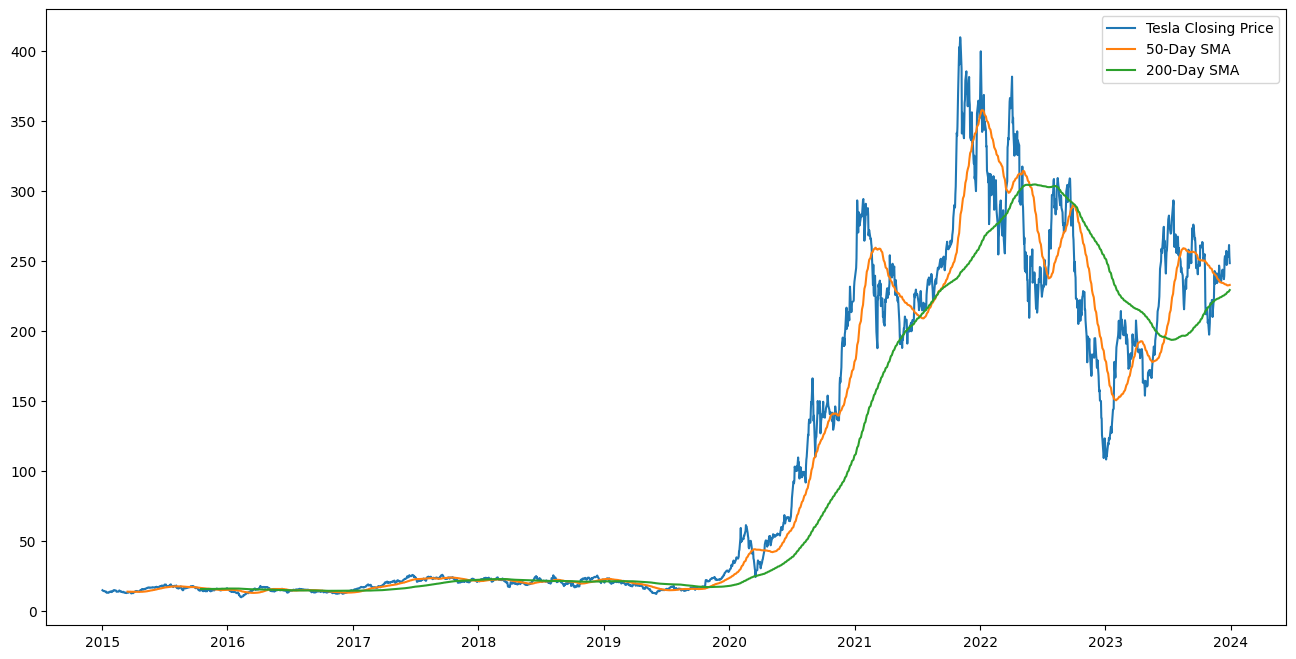

In [ ]:
# Data visualization along with SMAs
plt.figure(figsize=(16, 8))
plt.plot(df['Close'], label='Tesla Closing Price')
plt.plot(df['SMA50'], label='50-Day SMA')
plt.plot(df['SMA200'], label='200-Day SMA')
plt.legend()
plt.show()

>**Observation:** From the plot it is found that for a short term reliable prediction a window size near 50 is a starting choice!

#### Data preparation for AI models

In [ ]:
# Preprocessing and sequence creation
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))
sequence_length = 60

In [ ]:
# --- creating a sequence of data chunks with 60 days data as X and next value as the y as input response pair.
def create_sequences(data, sequence_length):
    sequences = []
    state = []
    for i in range(len(data) - sequence_length):
        seq = data[i : i + sequence_length]
        pred = data[i + sequence_length]
        sequences.append(seq)
        state.append(pred)
    return np.array(sequences), np.array(state)

X, y = create_sequences(scaled_data, sequence_length)

#### Creating a train test subset for model training and testing

In [ ]:
# Splitting data to train and test subsets- 80% data for training and 20% for testing.
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

#### Building AI models for Tesla stock price prediction task

In the first trial design a very simple model with one layer.

In [ ]:
## Define AI models
## 1. RNN
rnn_model = Sequential([
    SimpleRNN(50, activation='relu', return_sequences=True,input_shape=(sequence_length,1)),
    SimpleRNN(50, activation='relu'),
    Dense(1)
])
rnn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)             │ (None, 60, 50)              │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,701 (30.08 KB)

 Trainable params: 7,701 (30.08 KB)

 Non-trainable params: 0 (0.00 B)

**Model Training**:
   - Trained Vanilla RNN, LSTM, and GRU models for 50 epochs.
   - Recorded training times and evaluated performance on the validation set.


#### Compile, train and save the RNN variants one by one

In [ ]:
import time
rnn_model.compile(optimizer='adam', loss='mse')
start_time=time.time()
rnn_model.fit(X_train, y_train, epochs=20, batch_size=32)
training_time=time.time()-start_time
print(f"Total training time for RNN model is:{training_time}")
print("RNN model is saving.....")
rnn_model.save('tesla_rnn_model.h5')
print("RNN model is successfully saved!")

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0026
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.4408e-04
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.2592e-04
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.9531e-04
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.2491e-04
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.4093e-04
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.6515e-04
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.7706e-04
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8820e-04
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.9816e-04
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7626e-04
Epoch 12/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.8040e-04
Epoch 13/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.9715e-04
Epoch 14/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.9609e-04
Epoch 15/20
56/56 ━━━━━━━━━━━━

Total training time for RNN model is:18.81477379798889
RNN model is saving.....
RNN model is successfully saved!


In [ ]:
## 2. LSTM
lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True,input_shape=(sequence_length, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])
lstm_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_model.compile(optimizer='adam', loss='mse')
start_time=time.time()
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32)
training_time = time.time() - start_time
print(f"LSTM Model Training Time: {training_time:.2f} seconds")
print("LSTM model is saving.....")
lstm_model.save('tesla_lstm_model.h5')
print("LSTM model is successfully saved!")

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0499
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0012
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.5550e-04
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0011
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.5495e-04
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0010
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.7799e-04
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.2430e-04
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0012
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.5504e-04
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.7907e-04
Epoch 12/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.0688e-04
Epoch 13/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.2941e-04
Epoch 14/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.2091e-04
Epoch 15/20
56/56 ━━━━━━━━━━━━━━━━━

LSTM Model Training Time: 27.21 seconds
LSTM model is saving.....
LSTM model is successfully saved!


In [ ]:
# 3. GRU
gru_model = Sequential([
    GRU(50, activation='relu', return_sequences=True,input_shape=(sequence_length, 1)),
    GRU(50, activation='relu'),
    Dense(1)
])
gru_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                          │ (None, 60, 50)              │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,301 (91.02 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
gru_model.compile(optimizer='adam', loss='mse')
start_time=time.time()
gru_model.fit(X_train, y_train, epochs=20, batch_size=32)
training_time = time.time() - start_time
print(f"GRU Model Training Time: {training_time:.2f} seconds")
print("GRU model is saving.....")
gru_model.save('tesla_gru_model.h5')
print("GRU model is saved successfully!")

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0437
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.9326e-04
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.4185e-04
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.9987e-04
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.6091e-04
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.5166e-04
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.4723e-04
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.9887e-04
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.4846e-04
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.4214e-04
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0348e-04
Epoch 12/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6020e-04
Epoch 13/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.3029e-04
Epoch 14/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.0713e-04
Epoch 15/20
56/56 ━

GRU Model Training Time: 22.06 seconds
GRU model is saving.....
GRU model is saved successfully!


#### Model Comparison in terms of inference time

In [ ]:
# Load models and run inference with inference time calulation
import time
from keras.models import load_model

model_paths = ['tesla_rnn_model.h5', 'tesla_lstm_model.h5', 'tesla_gru_model.h5']
model_names = ['RNN', 'LSTM', 'GRU']

predictions = {}
inference_times = {}

# Loop through models and record inference time
for model_path, model_name in zip(model_paths, model_names):
    model = load_model(model_path, compile=False)
    model.compile(optimizer='adam', loss='mse')

    start_infer = time.time()
    pred = model.predict(X_test)
    end_infer = time.time()

    predictions[model_name] = pred
    inference_times[model_name] = end_infer - start_infer

# Print inference times
for model_name, infer_time in inference_times.items():
    print(f'{model_name} Inference Time: {infer_time:.2f} seconds')

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
RNN Inference Time: 2.59 seconds
LSTM Inference Time: 2.59 seconds
GRU Inference Time: 1.45 seconds


>**Observation: RNN is the winner in inference time test**

**Performance Evaluation**:
   - Calculated RMSE, MAE, and R² Score for each model on the test set.
   - Measured inference times to compare computational efficiency.

#### Comparison of models using evaluation metrics

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
from keras.models import load_model

model_paths = ['tesla_rnn_model.h5', 'tesla_lstm_model.h5', 'tesla_gru_model.h5']
model_names = ['RNN', 'LSTM', 'GRU']

predictions = {}
inference_times = {}

# Loop through models and record inference time and metrics
for model_path, model_name in zip(model_paths, model_names):
    model = load_model(model_path, compile=False)
    model.compile(optimizer='adam', loss='mse')

    start_infer = time.time()
    pred = model.predict(X_test)
    end_infer = time.time()

    predictions[model_name] = pred
    inference_times[model_name] = end_infer - start_infer

    # Reshape and inverse transform predictions
    pred = pred.reshape(-1, 1)
    pred = scaler.inverse_transform(pred)

    # Compute metrics
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)

    # Print metrics
    print(f"{model_name} Metrics:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R^2 Score: {r2:.2f}")
    print(f"Inference Time: {inference_times[model_name]:.2f} seconds\n")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
RNN Metrics:
RMSE: 228.59
MAE: 223.28
R^2 Score: -3248025.64
Inference Time: 1.31 seconds

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step
LSTM Metrics:
RMSE: 229.89
MAE: 224.95
R^2 Score: -3285249.01
Inference Time: 2.59 seconds

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
GRU Metrics:
RMSE: 246.55
MAE: 241.11
R^2 Score: -3778544.48
Inference Time: 2.59 seconds



>**Observarions:** Since the error values are extremly high and the $R^2$ value is negative, none of these models learn the pattern in the Tesla stock price. The main reason is that these models trained only 20 epochs in this large dataset. This obdervations will be confirmed through the following visualizations.

**Future Price Prediction**:
   - Generated 15-day and 5-day forecasts using the trained models.
   - Visualized predictions alongside actual prices to assess alignment.


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

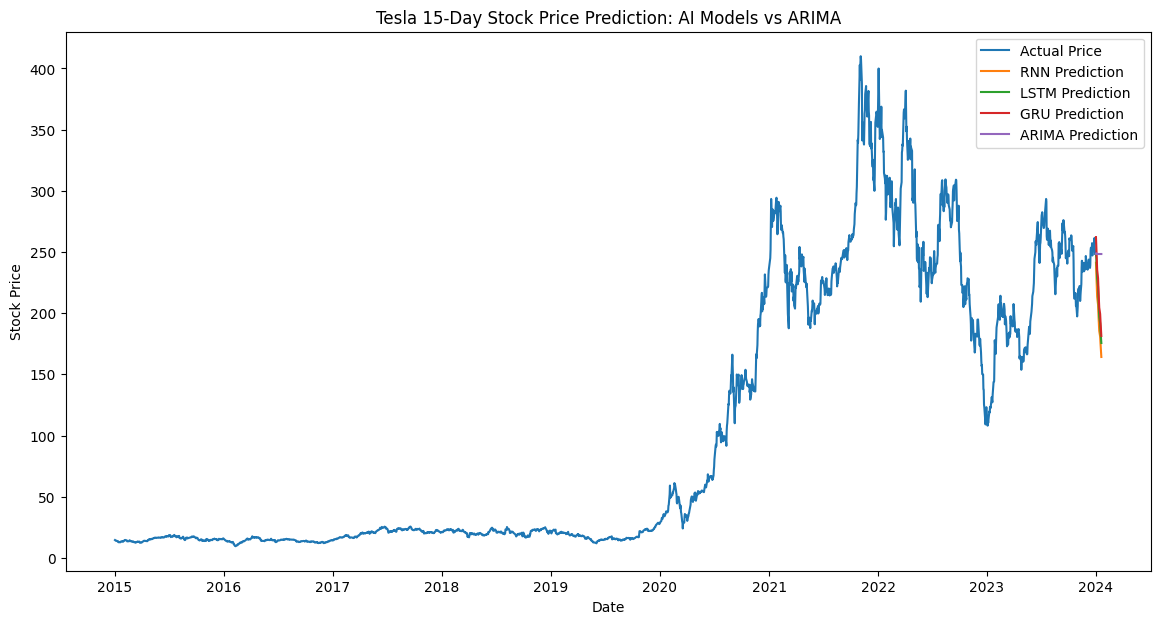

In [ ]:
# Import necessary libraries
from statsmodels.tsa.arima.model import ARIMA

# Define the number of future steps to forecast
future_steps = 15

# Fit the ARIMA model on the historical 'Close' prices
# Using order=(p, d, q) where p=5, d=1, q=0 as an example
arima_model = ARIMA(df['Close'], order=(5, 1, 0))  # p (lags)=5, d=1 (difference), q=0 (number of moving average terms)
arima_model_fit = arima_model.fit()

# Forecast the next 15 days using the fitted ARIMA model
arima_future = arima_model_fit.forecast(steps=future_steps)

# Create future sequences for AI models
future_inputs = scaled_data[-sequence_length:]

# Extend predictions for each model
rnn_future = []
lstm_future = []
gru_future = []

for _ in range(future_steps):
    rnn_pred = rnn_model.predict(future_inputs.reshape(1, sequence_length, 1)).flatten()
    lstm_pred = lstm_model.predict(future_inputs.reshape(1, sequence_length, 1)).flatten()
    gru_pred = gru_model.predict(future_inputs.reshape(1, sequence_length, 1)).flatten()

    rnn_future.append(rnn_pred)
    lstm_future.append(lstm_pred)
    gru_future.append(gru_pred)

    # Update the input sequence with the latest prediction (using RNN's prediction)
    future_inputs = np.append(future_inputs[1:], rnn_pred.reshape(-1, 1), axis=0)

# Convert to numpy arrays and inverse transform the predictions
rnn_future = scaler.inverse_transform(np.array(rnn_future).reshape(-1, 1))
lstm_future = scaler.inverse_transform(np.array(lstm_future).reshape(-1, 1))
gru_future = scaler.inverse_transform(np.array(gru_future).reshape(-1, 1))

# Plot predictions
plt.figure(figsize=(14, 7))
plt.plot(df.index[:], df['Close'].iloc[:], label='Actual Price')
plt.plot(pd.date_range(start=df.index[-1], periods=future_steps + 1, freq='B')[1:], rnn_future, label='RNN Prediction')
plt.plot(pd.date_range(start=df.index[-1], periods=future_steps + 1, freq='B')[1:], lstm_future, label='LSTM Prediction')
plt.plot(pd.date_range(start=df.index[-1], periods=future_steps + 1, freq='B')[1:], gru_future, label='GRU Prediction')
plt.plot(pd.date_range(start=df.index[-1], periods=future_steps + 1, freq='B')[1:], arima_future, label='ARIMA Prediction')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.title('Tesla 15-Day Stock Price Prediction: AI Models vs ARIMA')
plt.show()

>**Observation:** From the prediction plot, its is clear that none of the AI models cature the stock price pattern!

#### A zoomed version of the plot!

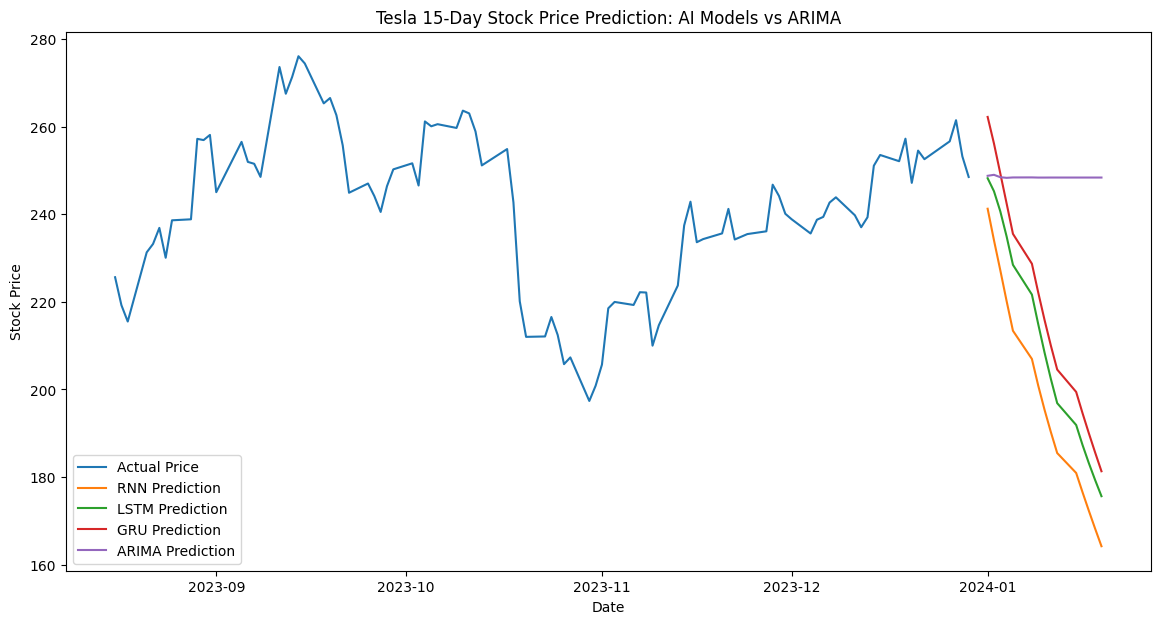

In [ ]:
# Plot predictions
plt.figure(figsize=(14, 7))
plt.plot(df.index[-95:], df['Close'].iloc[-95:], label='Actual Price')
plt.plot(pd.date_range(start=df.index[-1], periods=future_steps+1, freq='B')[1:], rnn_future, label='RNN Prediction')
plt.plot(pd.date_range(start=df.index[-1], periods=future_steps+1, freq='B')[1:], lstm_future, label='LSTM Prediction')
plt.plot(pd.date_range(start=df.index[-1], periods=future_steps+1, freq='B')[1:], gru_future, label='GRU Prediction')
plt.plot(pd.date_range(start=df.index[-1], periods=future_steps+1, freq='B')[1:], arima_future, label='ARIMA Prediction')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.title('Tesla 15-Day Stock Price Prediction: AI Models vs ARIMA')
plt.show()

### Next step:
From the model analysis, it is found that all the models must run atleast 50 to 100 epochs to learn the stock price pattern.


## Build a mode deep RNN variants for better prediction

[*********************100%***********************]  1 of 1 completed


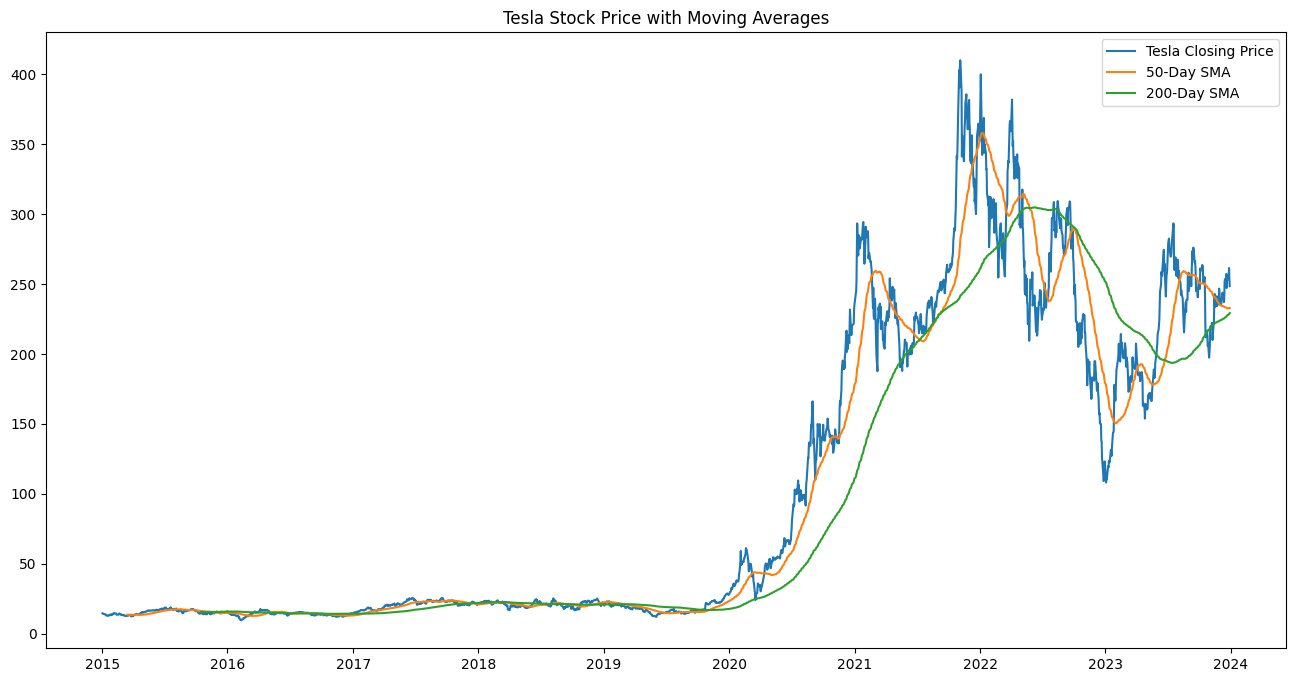

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training RNN model...
Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.3850e-04 - val_loss: 0.0015
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.8266e-04 - val_loss: 0.0045
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.6584e-04 - val_loss: 0.0052
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.3095e-04 - val_loss: 0.0023
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.9416e-04 - val_loss: 0.0060
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.4212e-04 - val_loss: 0.0017
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2282e-04 - val_loss: 0.0014
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.1529e-04 - val_loss: 0.0063
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.4553e-04 - val_loss: 0.0031
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.5607e-04 - val_loss: 0.0039
E

RNN Model Training Time: 37.76 seconds
Training LSTM model...
Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - loss: 0.0034 - val_loss: 0.1955
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 2.5816e-04 - val_loss: 0.0303
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.2929e-04 - val_loss: 0.0086
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.7711e-04 - val_loss: 0.0078
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.2633e-04 - val_loss: 0.0054
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.0800e-04 - val_loss: 0.0049
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.2458e-04 - val_loss: 0.0056
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.7984e-04 - val_loss: 0.0042
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.1227e-04 - val_loss: 0.0122
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.8662e-04 - val_loss: 0.0041
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

LSTM Model Training Time: 47.00 seconds
Training GRU model...
Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 2.8726e-04 - val_loss: 0.0048
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.6296e-04 - val_loss: 0.0046
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.8042e-04 - val_loss: 0.0029
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.7954e-04 - val_loss: 0.0042
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.5711e-04 - val_loss: 0.0120
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.3325e-04 - val_loss: 0.0018
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.0818e-04 - val_loss: 0.0113
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.9542e-04 - val_loss: 0.0114
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.2079e-04 - val_loss: 0.0046
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/st

GRU Model Training Time: 59.90 seconds
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
RNN Metrics:
RMSE: 15.40
MAE: 12.98
R^2 Score: 0.91
Inference Time: 1.31 seconds

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
LSTM Metrics:
RMSE: 46.72
MAE: 41.00
R^2 Score: 0.15
Inference Time: 1.31 seconds

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
GRU Metrics:
RMSE: 27.13
MAE: 23.82
R^2 Score: 0.71
Inference Time: 1.34 seconds



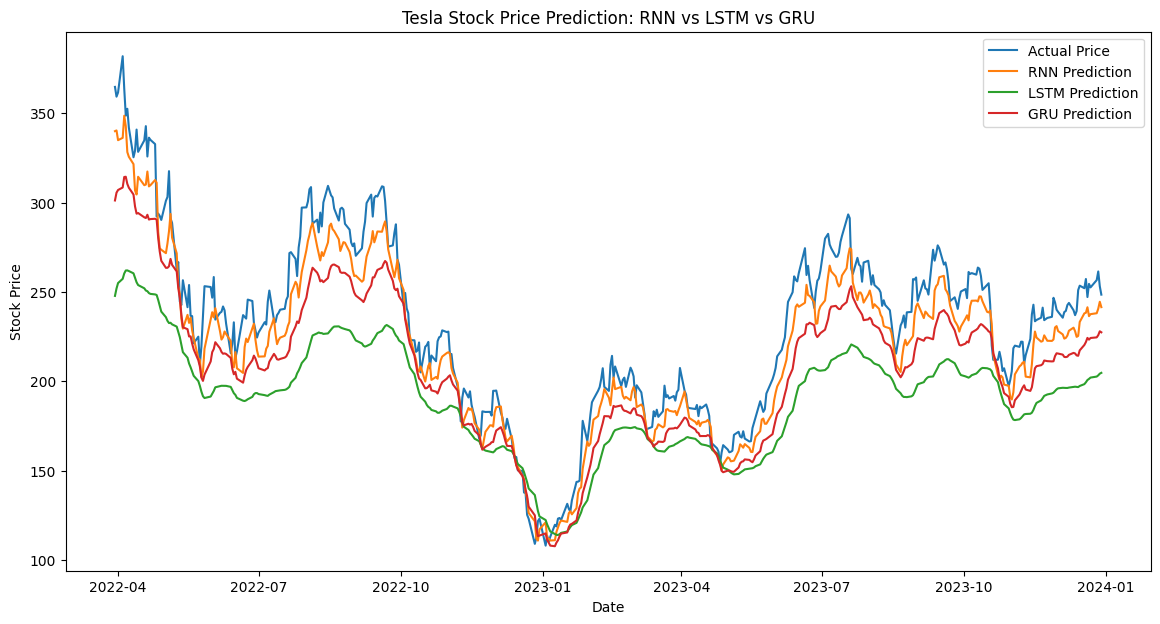

RNN Performance:
RMSE: 15.40
MAE: 12.98
R^2 Score: 0.91
Inference Time: 1.31 seconds

LSTM Performance:
RMSE: 46.72
MAE: 41.00
R^2 Score: 0.15
Inference Time: 1.31 seconds

GRU Performance:
RMSE: 27.13
MAE: 23.82
R^2 Score: 0.71
Inference Time: 1.34 seconds



In [ ]:
# full code to save as a .py file to upload in GitHub.


import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

# Fetch Tesla stock data
ticker = 'TSLA'
start_date = '2015-01-01'
end_date = '2024-01-01'

df = yf.download(ticker, start=start_date, end=end_date)

# Initial analysis of Tesla stock price
df['SMA50'] = df['Close'].rolling(window=50).mean()
df['SMA200'] = df['Close'].rolling(window=200).mean()
df['Returns'] = df['Close'].pct_change()

# Data visualization
plt.figure(figsize=(16, 8))
plt.plot(df['Close'], label='Tesla Closing Price')
plt.plot(df['SMA50'], label='50-Day SMA')
plt.plot(df['SMA200'], label='200-Day SMA')
plt.legend()
plt.title('Tesla Stock Price with Moving Averages')
plt.show()

# Preprocessing and sequence creation
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

sequence_length = 60

def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[i : i + sequence_length]
        pred = data[i + sequence_length]
        sequences.append(seq)
        labels.append(pred)
    return np.array(sequences), np.array(labels)

X, y = create_sequences(scaled_data, sequence_length)

# Splitting data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define AI models
def build_rnn_model():
    model = Sequential([
        SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)),
        Dropout(0.2),
        SimpleRNN(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    return model

def build_lstm_model():
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    return model

def build_gru_model():
    model = Sequential([
        GRU(50, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)),
        Dropout(0.2),
        GRU(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    return model

# Compile and train models
models = {
    'RNN': build_rnn_model(),
    'LSTM': build_lstm_model(),
    'GRU': build_gru_model()
}

for model_name, model in models.items():
    model.compile(optimizer='adam', loss='mse')
    print(f"Training {model_name} model...")
    start_time = time.time()
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
    training_time = time.time() - start_time
    print(f"{model_name} Model Training Time: {training_time:.2f} seconds")
    model.save(f'tesla_{model_name.lower()}_model.h5')

# Evaluation of models
predictions = {}
metrics = {}

for model_name, model in models.items():
    model = load_model(f'tesla_{model_name.lower()}_model.h5',compile=False)
    model.compile(optimizer='adam', loss='mse')
    start_infer = time.time()
    pred = model.predict(X_test)
    end_infer = time.time()

    # Inverse transform predictions
    pred = scaler.inverse_transform(pred.reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Compute metrics
    rmse = np.sqrt(mean_squared_error(y_test_actual, pred))
    mae = mean_absolute_error(y_test_actual, pred)
    r2 = r2_score(y_test_actual, pred)

    # Store results
    predictions[model_name] = pred
    metrics[model_name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Inference Time': end_infer - start_infer
    }

    # Print metrics
    print(f"{model_name} Metrics:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R^2 Score: {r2:.2f}")
    print(f"Inference Time: {metrics[model_name]['Inference Time']:.2f} seconds\n")

# Plot predictions
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test_actual, label='Actual Price')
for model_name, pred in predictions.items():
    plt.plot(df.index[-len(y_test):], pred, label=f'{model_name} Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.title('Tesla Stock Price Prediction: RNN vs LSTM vs GRU')
plt.show()

# Compare model performance
for model_name, metric in metrics.items():
    print(f"{model_name} Performance:")
    print(f"RMSE: {metric['RMSE']:.2f}")
    print(f"MAE: {metric['MAE']:.2f}")
    print(f"R^2 Score: {metric['R2']:.2f}")
    print(f"Inference Time: {metric['Inference Time']:.2f} seconds\n")

>**Observation:** Even with these updations, only RNN shows some promising improvements. $R^2$ value greater than 0.75 is a good indicator for model's predictive power and generalizability.

### Comparison of 5 days stock price prediction with all trained models

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


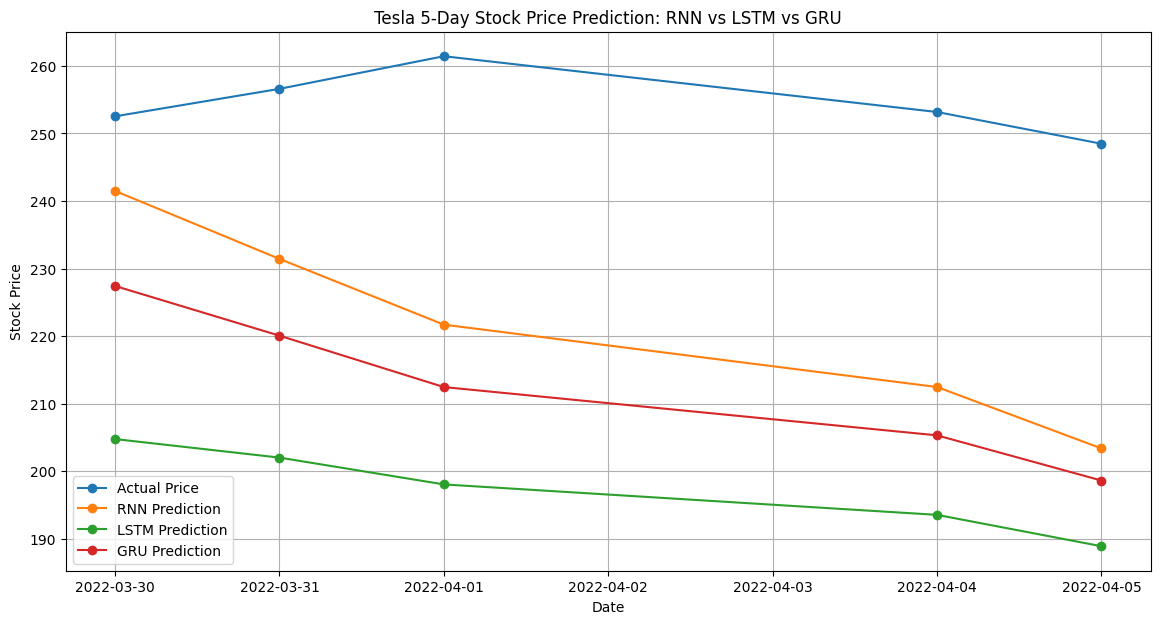

In [ ]:
# Function to load models and generate 5-day predictions
def load_models_and_predict(models_to_load, X_input, scaler, days_ahead=5):
    predictions = {}
    for model_name in models_to_load:
        model = load_model(f'tesla_{model_name.lower()}_model.h5', compile=False)
        model.compile(optimizer='adam', loss='mse')

        # Ensure X_input is in the correct shape (num_samples, sequence_length, num_features)
        if len(X_input.shape) == 2:
            X_input = X_input.reshape((X_input.shape[0], X_input.shape[1], 1))

        # Use the last sequence from the input data
        future_input = X_input[-1]  # Shape: (sequence_length, 1)
        future_predictions = []

        for _ in range(days_ahead):
            # Reshape input to match model's expected input shape (batch_size, sequence_length, features)
            pred = model.predict(future_input.reshape(1, sequence_length, 1))
            future_predictions.append(pred[0][0])  # Append the predicted value

            # Update input for next prediction by removing the first element and appending the new prediction
            future_input = np.append(future_input[1:], pred, axis=0)

        # Inverse transform predictions to original scale
        future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
        predictions[model_name] = future_predictions

    return predictions

# Load models and generate 5-day predictions
models_to_load = ['RNN', 'LSTM', 'GRU']
predictions = load_models_and_predict(models_to_load, X_test, scaler, days_ahead=5)

# Plot 5-day predictions along with actual values
plt.figure(figsize=(14, 7))

# Get the last 5 actual values from the test set
actual_values = scaler.inverse_transform(y_test[-5:].reshape(-1, 1))

# Generate dates for the last 5 days of the test set
last_date = df.index[-len(y_test)]
dates = pd.date_range(start=last_date, periods=5, freq='B')

# Plot actual values
plt.plot(dates, actual_values, label='Actual Price', marker='o')

# Plot predictions for each model
for model_name, pred in predictions.items():
    plt.plot(dates, pred, label=f'{model_name} Prediction', marker='o')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.title('Tesla 5-Day Stock Price Prediction: RNN vs LSTM vs GRU')
plt.grid()
plt.show()

### Fine tuning the models for realistic predictions

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


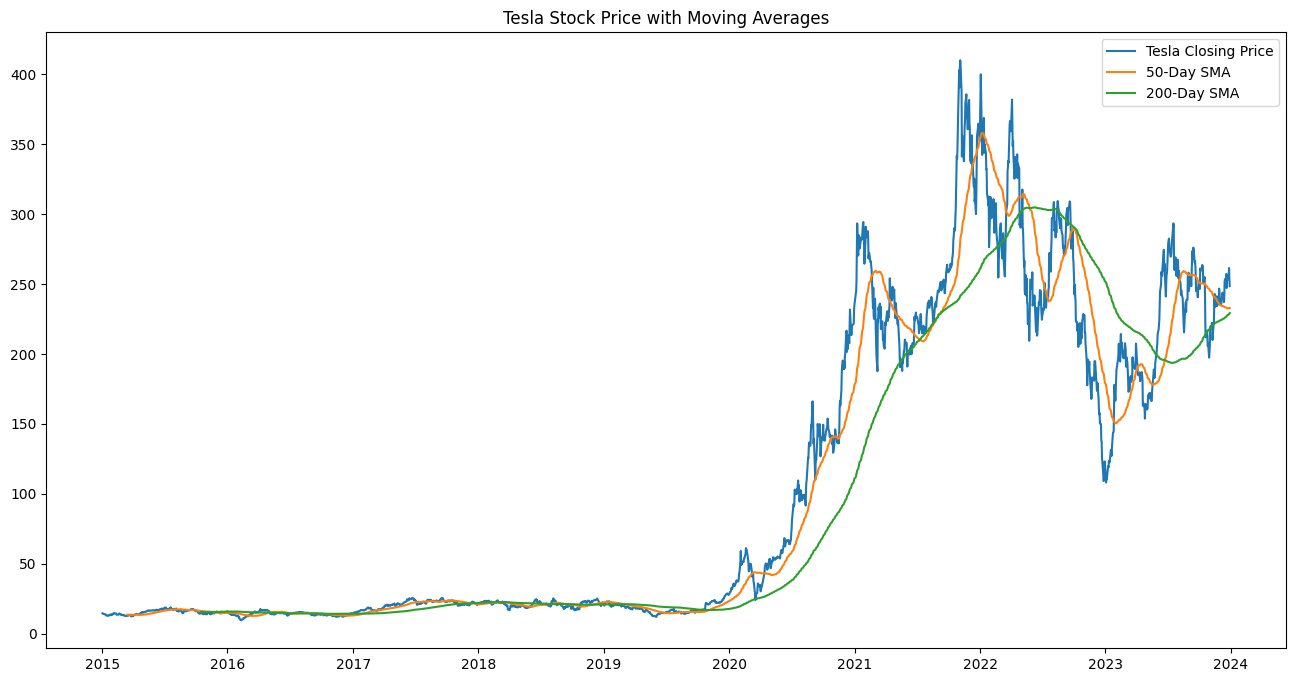

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training RNN model...
Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 38s 417ms/step - loss: 2.3656 - val_loss: 0.5200 - learning_rate: 0.0010
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6080 - val_loss: 0.4369 - learning_rate: 0.0010
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.9828 - val_loss: 0.2860 - learning_rate: 0.0010
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8477 - val_loss: 0.3198 - learning_rate: 0.0010
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.6345 - val_loss: 0.4700 - learning_rate: 0.0010
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6682 - val_loss: 0.3393 - learning_rate: 0.0010
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.4954 - val_loss: 0.4278 - learning_rate: 0.0010
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.5349 - val_loss: 0.4745 - learning_rate: 0.0010
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.4382 - val_loss: 0.3182 - learning

RNN Model Training Time: 142.60 seconds
Training LSTM model...
Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 186ms/step - loss: 1.2478 - val_loss: 0.6662 - learning_rate: 0.0010
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.9159 - val_loss: 0.7078 - learning_rate: 0.0010
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7696 - val_loss: 0.6907 - learning_rate: 0.0010
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.6276 - val_loss: 0.7043 - learning_rate: 0.0010
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.5308 - val_loss: 0.7545 - learning_rate: 0.0010
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.5456 - val_loss: 0.6530 - learning_rate: 0.0010
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.4555 - val_loss: 0.6136 - learning_rate: 0.0010
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.4778 - val_loss: 0.6410 - learning_rate: 0.0010
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - l

LSTM Model Training Time: 127.72 seconds
Training GRU model...
Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 192ms/step - loss: 2.0483 - val_loss: 0.7166 - learning_rate: 0.0010
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 1.6282 - val_loss: 0.8034 - learning_rate: 0.0010
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.9940 - val_loss: 0.9181 - learning_rate: 0.0010
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.9630 - val_loss: 1.0470 - learning_rate: 0.0010
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.9389 - val_loss: 1.0202 - learning_rate: 0.0010
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7946 - val_loss: 0.8044 - learning_rate: 0.0010
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.8076 - val_loss: 0.9018 - learning_rate: 0.0010
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.6940 - val_loss: 0.7231 - learning_rate: 0.0010
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - l

GRU Model Training Time: 138.61 seconds
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step
RNN Metrics:
RMSE: 70.65
MAE: 59.05
R^2 Score: -0.94
Inference Time: 2.60 seconds

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step
LSTM Metrics:
RMSE: 33372.69
MAE: 4586.93
R^2 Score: -431839.07
Inference Time: 2.14 seconds

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step
GRU Metrics:
RMSE: 171.49
MAE: 159.70
R^2 Score: -10.40
Inference Time: 2.19 seconds



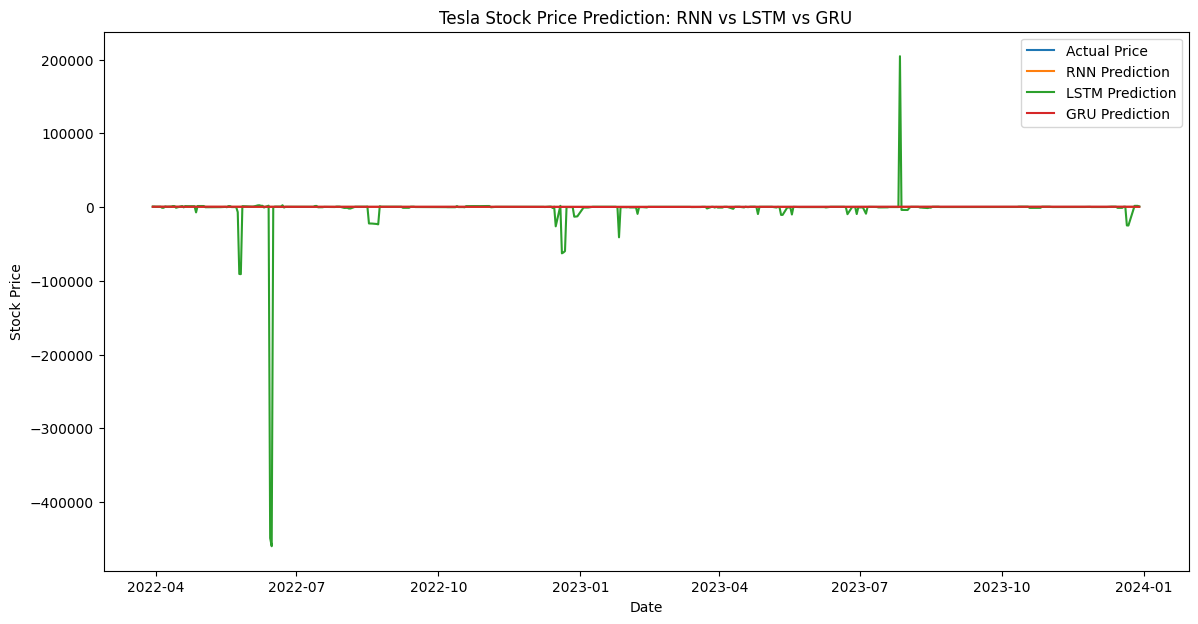

RNN Performance:
RMSE: 70.65
MAE: 59.05
R^2 Score: -0.94
Inference Time: 2.60 seconds

LSTM Performance:
RMSE: 33372.69
MAE: 4586.93
R^2 Score: -431839.07
Inference Time: 2.14 seconds

GRU Performance:
RMSE: 171.49
MAE: 159.70
R^2 Score: -10.40
Inference Time: 2.19 seconds



In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
from tensorflow.keras.callbacks import LearningRateScheduler

# Fetch Tesla stock data
ticker = 'TSLA'
start_date = '2015-01-01'
end_date = '2024-01-01'

df = yf.download(ticker, start=start_date, end=end_date)


# Preprocessing and sequence creation
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

sequence_length = 50

def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[i : i + sequence_length]
        pred = data[i + sequence_length]
        sequences.append(seq)
        labels.append(pred)
    return np.array(sequences), np.array(labels)

X, y = create_sequences(scaled_data, sequence_length)

# Splitting data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define AI models with regularization and deeper architecture
def build_rnn_model():
    model = Sequential([
        SimpleRNN(100, activation='relu', return_sequences=True,
                  input_shape=(sequence_length, 1), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        SimpleRNN(100, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        SimpleRNN(50, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(1, kernel_regularizer=l2(0.001))
    ])
    return model

def build_lstm_model():
    model = Sequential([
        LSTM(100, activation='relu', return_sequences=True,
             input_shape=(sequence_length, 1), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        LSTM(100, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        LSTM(50, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(1, kernel_regularizer=l2(0.001))
    ])
    return model

def build_gru_model():
    model = Sequential([
        GRU(100, activation='relu', return_sequences=True,
            input_shape=(sequence_length, 1), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        GRU(100, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        GRU(50, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(1, kernel_regularizer=l2(0.001))
    ])
    return model

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.95

lr_callback = LearningRateScheduler(lr_scheduler)

# Compile and train models
models = {
    'RNN': build_rnn_model(),
    'LSTM': build_lstm_model(),
    'GRU': build_gru_model()
}

for model_name, model in models.items():
    model.compile(optimizer='adam', loss='mse')
    print(f"Training {model_name} model...")
    start_time = time.time()
    model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        verbose=1,
        callbacks=[lr_callback]
    )
    training_time = time.time() - start_time
    print(f"{model_name} Model Training Time: {training_time:.2f} seconds")
    model.save(f'tesla_{model_name.lower()}_model.h5')

# Evaluation of models
predictions = {}
metrics = {}

for model_name, model in models.items():
    model = load_model(f'tesla_{model_name.lower()}_model.h5', compile=False)
    model.compile(optimizer='adam', loss='mse')
    start_infer = time.time()
    pred = model.predict(X_test)
    end_infer = time.time()

    # Inverse transform predictions
    pred = scaler.inverse_transform(pred.reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Compute metrics
    rmse = np.sqrt(mean_squared_error(y_test_actual, pred))
    mae = mean_absolute_error(y_test_actual, pred)
    r2 = r2_score(y_test_actual, pred)

    # Store results
    predictions[model_name] = pred
    metrics[model_name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Inference Time': end_infer - start_infer
    }

    # Print metrics
    print(f"{model_name} Metrics:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R^2 Score: {r2:.2f}")
    print(f"Inference Time: {metrics[model_name]['Inference Time']:.2f} seconds\n")

# Plot predictions
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test_actual, label='Actual Price')
for model_name, pred in predictions.items():
    plt.plot(df.index[-len(y_test):], pred, label=f'{model_name} Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Stock Price')
plt.legend()
plt.title('Tesla Stock Price Prediction on test data: RNN vs LSTM vs GRU')
plt.show()

# Compare model performance
for model_name, metric in metrics.items():
    print(f"{model_name} Performance:")
    print(f"RMSE: {metric['RMSE']:.2f}")
    print(f"MAE: {metric['MAE']:.2f}")
    print(f"R^2 Score: {metric['R2']:.2f}")
    print(f"Inference Time: {metric['Inference Time']:.2f} seconds\n")

## Conclusion:
 The actual stock price is higher the RNN LSTM and GRU predictions. LSTM prediction in this case is far away from actual and is an under estimated pattern. So further hyper parameter tuning and inclusion of more layers may give better prediction. Incorporating hyper=paramter tuning and regularization technique, a more deep model is trained on the same dataset. The results of the modified approach reveal significant challenges in the performance of the RNN, LSTM, and GRU models for Tesla stock price prediction. Results are given in the following table.

 | Model | RMSE     | MAE      | $R^2$ Score    | Inference Time |
|-------|----------|----------|-------------|----------------|
| RNN   | 70.65    | 59.05    | -0.94       | 2.60 seconds   |
| LSTM  | 33372.69 | 4586.93  | -431839.07  | 2.14 seconds   |
| GRU   | 171.49   | 159.70   | -10.40      | 2.19 seconds   |

From the model performance comparison table, it is clear that all the three models in the revised training setup are not acceptable. (Since the $R^2$ score is negative). The RNN variants are extrement poor performeres compared to the simple mean predicter. The table shows that the RNN model performs significantly better than LSTM and GRU, with the lowest RMSE (70.65) and MAE (59.05), despite having a negative $R^2$ score (-0.94), indicating poor explanatory power. The LSTM model performs remarkably worse, with an extremely high RMSE (33,372.69) and a highly negative $R^2$ score (-431,839.07), suggesting severe overfitting or instability. The GRU model lies in between, with moderate error metrics but still fails to capture meaningful patterns, as reflected by its negative $R^$ score (-10.40).

The current implementation demonstrates that Vanilla RNN, LSTM, and GRU models struggle to learn the complex patterns in Tesla stock price data when trained for only 50 epochs. The high error metrics and negative $R^2$ scores in the first and the last trials indicate that the models fail to generalize well with the simple architectures. Additionally, the predictions for future stock prices were inaccurate, highlighting the limitations of these models in handling volatile financial data.




### **Limitations of Present Work**
1. Training for only 50-100 epochs may not be enough for the models to fully learn the underlying patterns.
2. The dataset spans over 10 years, but it may still lack sufficient variability to train robust models.
3. The models rely solely on historical closing prices, ignoring other potential features like trading volume, news sentiment, or macroeconomic indicators that generally influence the stock price.
4. The architecture is relatively simple, with only two or three recurrent layers and minimal hyperparameter tuning.




### **Recommendations for improvement**
1. Increase the number of epochs to 100–200 inorder to allow the models to converge.
2. Incorporate additional features such as trading volume, technical indicators, and external factors like news sentiment (need additional feature engineering).
3. Experiment with hybrid models combining CNNs and RNNs to capture both spatial and temporal dependencies.
4. Apply hyper-parameter tuning.
5. Combine predictions from multiple models to improve accuracy.
6. Apply stronger regularization techniques  to reduce overfitting.